# New Section

In [ ]:
import os
import pandas as pd
df=pd.read_csv("train.csv")
#GOOGLE_DRIVE_PATH_AFTER_MYDRIVE ="CIS-511-NLP/finalproject/train.csv"
#df = pd.read_csv(os.path.join('drive','MyDrive',GOOGLE_DRIVE_PATH_AFTER_MYDRIVE))
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df_filtered = df[["comment_text", "toxic"]].rename(columns={"comment_text": "comment"})

In [ ]:
df_filtered.head()

,comment,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
# Filter toxic comments
toxic_comments = df_filtered[df_filtered["toxic"] == 1]
# Filter non-toxic comments
non_toxic_comments = df_filtered[df_filtered["toxic"] == 0]
# Display the counts
print(f"Number of toxic comments: {len(toxic_comments)}")
print(f"Number of non-toxic comments: {len(non_toxic_comments)}")

Number of toxic comments: 15294
Number of non-toxic comments: 144277


In [ ]:
!pip install imblearn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
# Undersample the majority class
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(df_filtered[['comment']], df_filtered['toxic'])
# Convert back to a DataFrame
df_resampled = pd.DataFrame({'comment': X_resampled['comment'], 'toxic': y_resampled})
# Display the class distribution
print(df_resampled['toxic'].value_counts())

toxic
0    15294
1    15294
Name: count, dtype: int64


In [ ]:
import re

# Function to remove punctuation and newlines
def clean_text(text):
    # Remove punctuation and newline characters
    text = re.sub(r'[^\w\s]', '', text)  # Removes all characters except letters, numbers, and whitespace
    text = re.sub(r'\n', ' ', text)  # Replaces newline characters with a space
    return text.strip()

# Apply cleaning to the 'comment' column
df_resampled['comment'] = df_resampled['comment'].apply(clean_text)
corpus = df_resampled['comment'].values.tolist()

In [ ]:
!pip install readability

  Preparing metadata (setup.py) ... done
  Created wheel for readability: filename=readability-0.3.1-py3-none-any.whl size=35461 sha256=cf95a72e2e95a8e73afcd8862da17b07770d45f44237079745115b8adf5d18b8
  Stored in directory: /root/.cache/pip/wheels/05/07/4d/2e3a0aaba1713619a403e1a3c56e88a6fc12d753872b98771c
Successfully built readability


In [ ]:
!pip install textstat
!pip install textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.7 MB/s eta 0:00:00


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from textstat import textstat  # Import textstat for readability features
from collections import Counter
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')

# List of offensive words (extend as needed)
OFFENSIVE_WORDS = {"hate", "stupid", "idiot", "fool", "ugly"}

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Feature extraction functions
def lexical_features(text):
    tokens = preprocess_text(text)

    return {
        "num_characters": len(text),
        "num_words": len(tokens),
        "num_sentences": len(sent_tokenize(text)),
        "avg_word_length": sum(len(word) for word in tokens) / len(tokens) if tokens else 0
    }
def sentiment(text):
    # Create the SentimentIntensityAnalyzer object
    sia = SentimentIntensityAnalyzer()

    # Get sentiment score for the text
    sentiment_score = sia.polarity_scores(text)['compound']

    # Convert sentiment score to numeric value
    if sentiment_score > 0:
        sentiment = 1  # Positive sentiment
    elif sentiment_score < 0:
        sentiment = -1  # Negative sentiment
    else:
        sentiment = 0  # Neutral sentiment

    # Return the sentiment as a numeric value
    return {
        "Sentiment": sentiment
    }
def syntactic_features(text):
    tokens = preprocess_text(text)
    pos_counts = Counter(tag for _, tag in pos_tag(tokens))
    return {
        "num_nouns": pos_counts.get('NN', 0),
        "num_verbs": pos_counts.get('VB', 0),
        "num_adjectives": pos_counts.get('JJ', 0),
    }

def domain_specific_features(text):
    tokens = preprocess_text(text)
    all_caps_words = [word for word in tokens if word.isupper()]
    toxic_keywords = [word for word in tokens if word in OFFENSIVE_WORDS]
    return {
        "num_all_caps_words": len(all_caps_words),
        "num_toxic_keywords": len(toxic_keywords)
    }

# Combine all features
def extract_features(text):
    features = {}
    features.update(lexical_features(text))
    features.update(syntactic_features(text))
    features.update(domain_specific_features(text))
    features.update(sentiment(text))
    return features

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk

In [ ]:
from tqdm import tqdm

batch_size = 1000
feature_set = []

for i in tqdm(range(0, len(corpus), batch_size), desc="Processing Batches"):
    batch = corpus[i:i + batch_size]
    batch_features = [extract_features(sample) for sample in batch]
    feature_set.extend(batch_features)

Processing Batches: 100%|██████████| 31/31 [16:41<00:00, 32.31s/it]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
feature_set = np.array(feature_set)

# Compute TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit top terms
tfidf_features = tfidf_vectorizer.fit_transform(corpus)
print("Vocabulary size:", len(tfidf_vectorizer.vocabulary_))

Vocabulary size: 5000


Python 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> 
KeyboardInterrupt
>>> 
KeyboardInterrupt
>>> 
KeyboardInterrupt
>>> ^C


In [ ]:
import pickle
with open('tfidf_model.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [ ]:
# import numpy as np
# from collections import Counter
# from itertools import combinations
# from nltk.tokenize import word_tokenize

# def compute_pmi_features(comments, vocabulary=None, window_size=5):
#     """
#     Compute PMI scores for frequent word pairs in a list of comments.

#     Parameters:
#     - comments: List of text strings (comments).
#     - vocabulary: List of words to consider for PMI (optional).
#     - window_size: Size of the sliding window for co-occurrence.

#     Returns:
#     - pmi_features: A 2D numpy array where each row corresponds to PMI features for a comment.
#     """
#     # Tokenize all comments and build a corpus-wide word frequency dictionary
#     tokenized_comments = [word_tokenize(comment.lower()) for comment in comments]
#     word_counts = Counter(word for comment in tokenized_comments for word in comment)

#     # Define vocabulary if not provided
#     if vocabulary is None:
#         vocabulary = list(word_counts.keys())

#     # Initialize co-occurrence counts
#     co_occurrence_counts = Counter()

#     # Compute co-occurrences within a sliding window
#     for tokens in tokenized_comments:
#         for i in range(len(tokens) - window_size + 1):
#             window = tokens[i:i + window_size]
#             for word1, word2 in combinations(window, 2):  # Unique word pairs
#                 if word1 in vocabulary and word2 in vocabulary:
#                     co_occurrence_counts[(word1, word2)] += 1

#     # Calculate total number of sliding windows
#     total_windows = sum(len(tokens) - window_size + 1 for tokens in tokenized_comments if len(tokens) >= window_size)

#     # Compute PMI scores for all word pairs in the vocabulary
#     pmi_scores = {}
#     for (word1, word2), co_count in co_occurrence_counts.items():
#         if co_count > 0:
#             p_word1 = word_counts[word1] / sum(word_counts.values())
#             p_word2 = word_counts[word2] / sum(word_counts.values())
#             p_word1_word2 = co_count / total_windows
#             if p_word1 > 0 and p_word2 > 0 and p_word1_word2 > 0:
#                 pmi = np.log(p_word1_word2 / (p_word1 * p_word2))
#                 pmi_scores[(word1, word2)] = pmi

#     # Build feature vectors for each comment
#     feature_matrix = []
#     for tokens in tokenized_comments:
#         # Calculate average PMI for word pairs in the comment
#         comment_pmi = []
#         for word1, word2 in combinations(tokens, 2):
#             if (word1, word2) in pmi_scores:
#                 comment_pmi.append(pmi_scores[(word1, word2)])
#         # Use mean PMI for the comment (or 0 if no pairs have PMI scores)
#         avg_pmi = np.mean(comment_pmi) if comment_pmi else 0
#         feature_matrix.append([avg_pmi])

#     return np.array(feature_matrix)

In [ ]:
# pmi_features = compute_pmi_features(corpus)

In [ ]:
# np.save("feature_set.npy", np.asarray([list(f.values()) for f in feature_set]))

In [ ]:
import numpy as np

n_samples = len(feature_set)
print(n_samples)
print(feature_set[0])


data = []

for i in range(n_samples):
  k = np.asarray([np.array(list(feature_set[i].values()), dtype=float)]).reshape(1, -1)
  j = tfidf_features[i].toarray()
  e = np.hstack((k, j))
  data.append(e.tolist())

30588
{'num_characters': 278, 'num_words': 25, 'num_sentences': 1, 'avg_word_length': 5.72, 'num_nouns': 13, 'num_verbs': 0, 'num_adjectives': 5, 'num_all_caps_words': 0, 'num_toxic_keywords': 0, 'Sentiment': 1}


In [ ]:
data_np = np.asarray(data)
n_features = data_np.shape[-1]
print(n_features)

5010


In [ ]:
X = data_np.reshape(-1, n_features)
y = df_resampled['toxic'].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
!pip install transformers

In [ ]:
!pip install xgboost
!pip install tensorflow

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import tensorflow as tf


model1 = RandomForestClassifier(n_estimators=100)
model2 = DecisionTreeClassifier()
model3 = LinearSVC()
model4 = XGBClassifier() #Nvidea implemented Classifier

# Define a simple deep learning model using Keras
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),  # Adjust input shape based on features
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification (use 'softmax' for multi-class)
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
              metrics=['accuracy'])

# Display model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │         320,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 322,817 (1.23 MB)

 Trainable params: 322,817 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)
# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6757 - loss: 0.9143 - val_accuracy: 0.8452 - val_loss: 0.3768
Epoch 2/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8453 - loss: 0.3917 - val_accuracy: 0.8341 - val_loss: 0.3830
Epoch 3/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8723 - loss: 0.3200 - val_accuracy: 0.8349 - val_loss: 0.4724
Epoch 4/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8954 - loss: 0.2779 - val_accuracy: 0.8624 - val_loss: 0.3178
Epoch 5/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9045 - loss: 0.2480 - val_accuracy: 0.8504 - val_loss: 0.4145
Epoch 6/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9002 - loss: 0.2588 - val_accuracy: 0.8998 - val_loss: 0.2485
Epoch 7/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9179 - loss: 0.2135 - val_accuracy: 0.8800 - val_loss: 0.3063
Epoch 8/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9173 - loss: 0.2187 - val_accuracy: 0

In [ ]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model3, f)

In [ ]:
from operator import mod
model1.score(X_train, y_train)
model2.score(X_train, y_train)
model3.score(X_train, y_train)
model4.score(X_train, y_train)
# Evaluate the model's performance on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy_Deeplearning: {test_accuracy * 100:.2f}%")



192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8729 - loss: 0.5744
Test Accuracy_Deeplearning: 87.17%


In [ ]:
predictions1 = model1.predict(X_test)
predictions2 = model2.predict(X_test)
predictions3 = model3.predict(X_test)
predictions4 = model4.predict(X_test)
# Make predictions
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)  # Thresholding for binary classification



192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc1 = accuracy_score(y_test, predictions1)
print(f"Randon Forest Test accuracy: {acc1*100:.3f}")
acc2 = accuracy_score(y_test, predictions2)
print(f"DecisionTree Test accuracy: {acc2*100:.3f}")
acc3 = accuracy_score(y_test, predictions3)
print(f"Linear SVC Test accuracy: {acc3*100:.3f}")
acc4 = accuracy_score(y_test, predictions4)
print(f"XGB Test accuracy: {acc4*100:.3f}")

Randon Forest Test accuracy: 86.319
DecisionTree Test accuracy: 78.947
Linear SVC Test accuracy: 90.307
XGB Test accuracy: 88.330


In [ ]:
cfm1 = confusion_matrix(y_test, predictions1)
cfm2 = confusion_matrix(y_test, predictions2)
cfm3 = confusion_matrix(y_test, predictions3)
cfm4 = confusion_matrix(y_test, predictions4)
cfmdeep = confusion_matrix(y_test,predicted_labels)

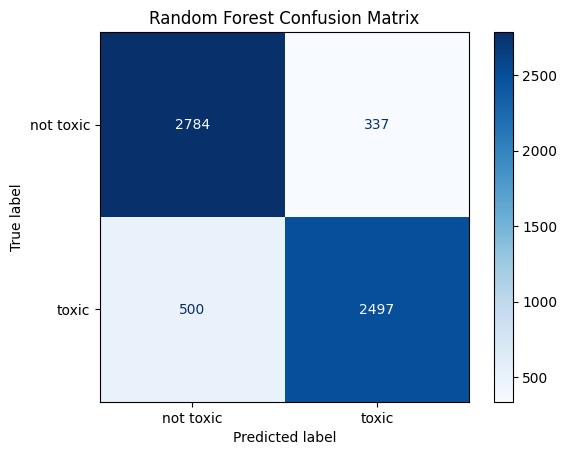

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp1 = ConfusionMatrixDisplay(confusion_matrix=cfm1, display_labels=["not toxic", "toxic"])
disp1.plot(cmap='Blues')  # Optional: Use a color map
plt.title("Random Forest Confusion Matrix")
plt.show()

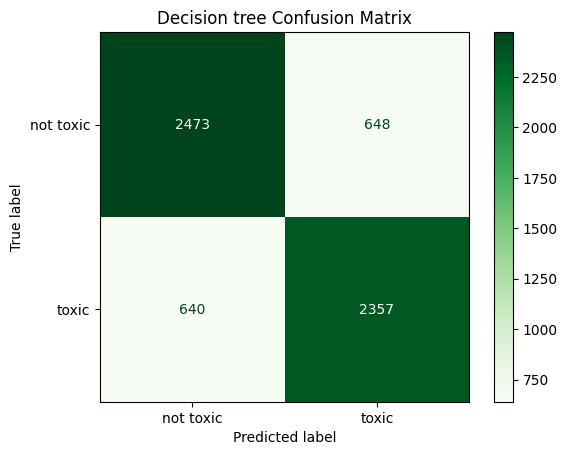

In [ ]:
disp2 = ConfusionMatrixDisplay(confusion_matrix=cfm2, display_labels=["not toxic", "toxic"])
disp2.plot(cmap='Greens')  # Optional: Use a color map
plt.title("Decision tree Confusion Matrix")
plt.show()

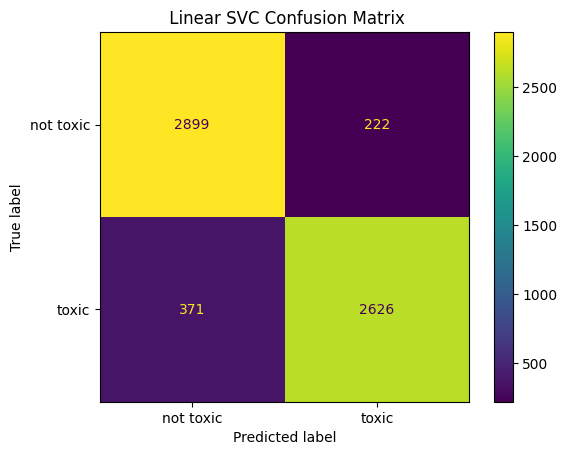

In [ ]:
disp3 = ConfusionMatrixDisplay(confusion_matrix=cfm3, display_labels=["not toxic", "toxic"])
disp3.plot(cmap='viridis')  # Optional: Use a color map
plt.title(" Linear SVC Confusion Matrix")
plt.show()


Threshold: 0.1
              precision    recall  f1-score   support

   not toxic       0.97      0.49      0.65      3121
       toxic       0.65      0.98      0.78      2997

    accuracy                           0.73      6118
   macro avg       0.81      0.73      0.71      6118
weighted avg       0.81      0.73      0.71      6118



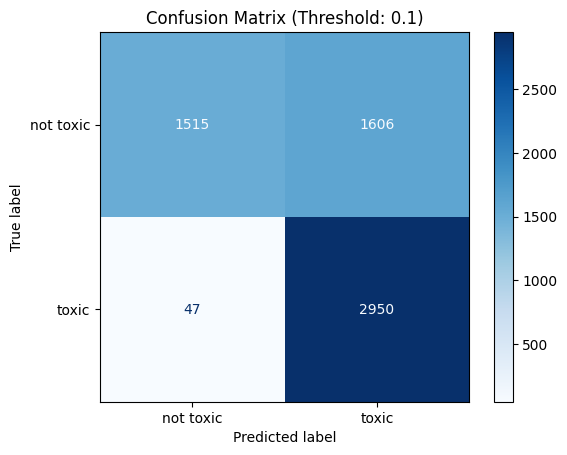


Threshold: 0.2
              precision    recall  f1-score   support

   not toxic       0.94      0.71      0.81      3121
       toxic       0.76      0.96      0.85      2997

    accuracy                           0.83      6118
   macro avg       0.85      0.83      0.83      6118
weighted avg       0.85      0.83      0.83      6118



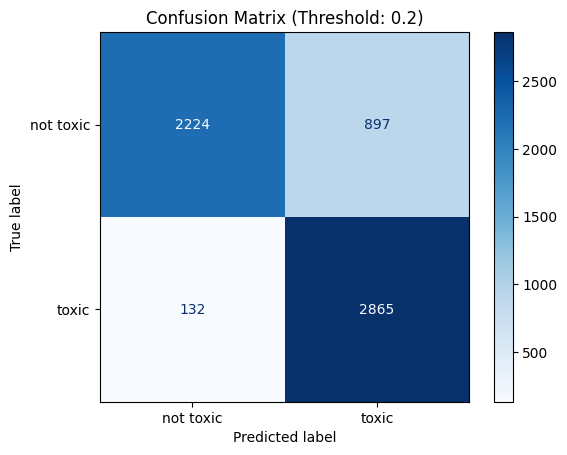


Threshold: 0.3
              precision    recall  f1-score   support

   not toxic       0.91      0.82      0.87      3121
       toxic       0.83      0.92      0.87      2997

    accuracy                           0.87      6118
   macro avg       0.87      0.87      0.87      6118
weighted avg       0.87      0.87      0.87      6118



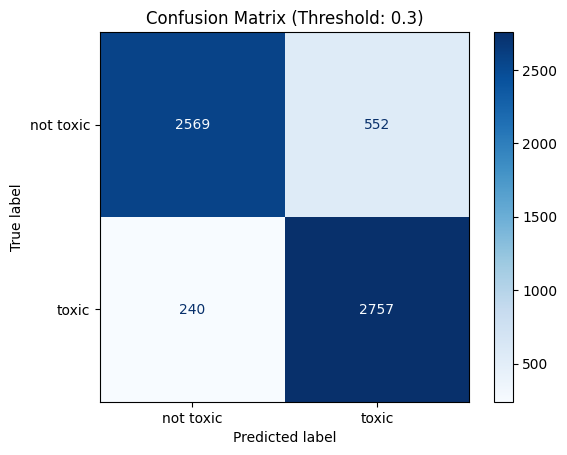


Threshold: 0.4
              precision    recall  f1-score   support

   not toxic       0.89      0.88      0.88      3121
       toxic       0.88      0.88      0.88      2997

    accuracy                           0.88      6118
   macro avg       0.88      0.88      0.88      6118
weighted avg       0.88      0.88      0.88      6118



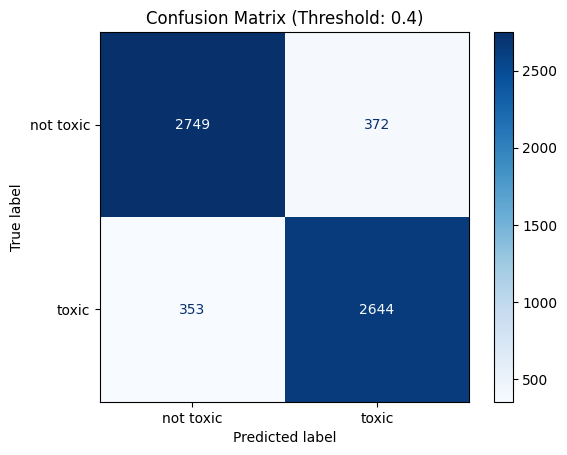


Threshold: 0.5
              precision    recall  f1-score   support

   not toxic       0.86      0.92      0.89      3121
       toxic       0.91      0.85      0.88      2997

    accuracy                           0.88      6118
   macro avg       0.89      0.88      0.88      6118
weighted avg       0.88      0.88      0.88      6118



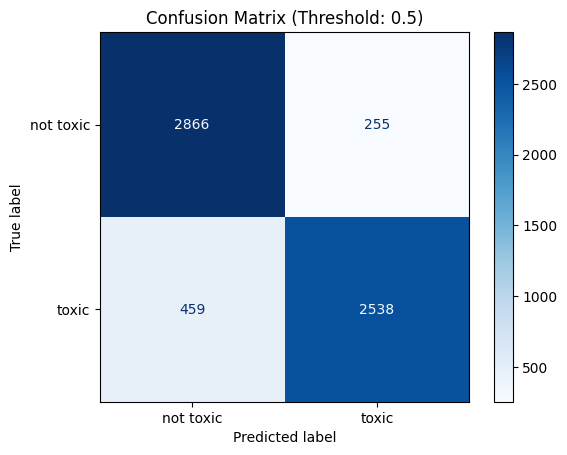


Threshold: 0.6
              precision    recall  f1-score   support

   not toxic       0.83      0.95      0.89      3121
       toxic       0.93      0.81      0.86      2997

    accuracy                           0.88      6118
   macro avg       0.88      0.88      0.88      6118
weighted avg       0.88      0.88      0.88      6118



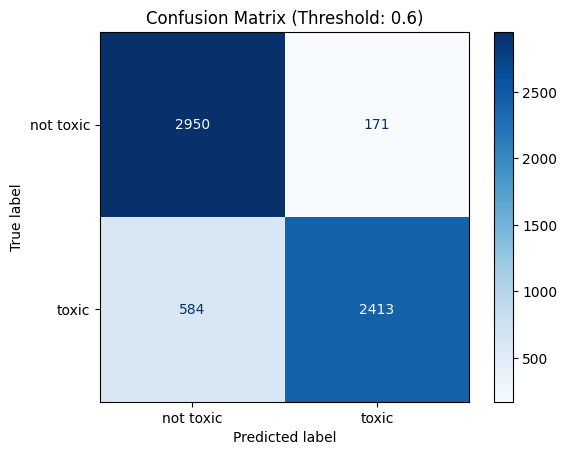


Threshold: 0.7
              precision    recall  f1-score   support

   not toxic       0.80      0.96      0.88      3121
       toxic       0.95      0.76      0.84      2997

    accuracy                           0.86      6118
   macro avg       0.88      0.86      0.86      6118
weighted avg       0.88      0.86      0.86      6118



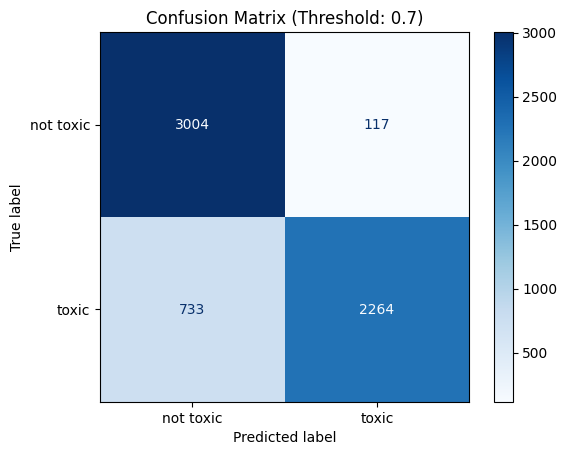


Threshold: 0.8
              precision    recall  f1-score   support

   not toxic       0.77      0.98      0.86      3121
       toxic       0.97      0.69      0.80      2997

    accuracy                           0.84      6118
   macro avg       0.87      0.83      0.83      6118
weighted avg       0.87      0.84      0.83      6118



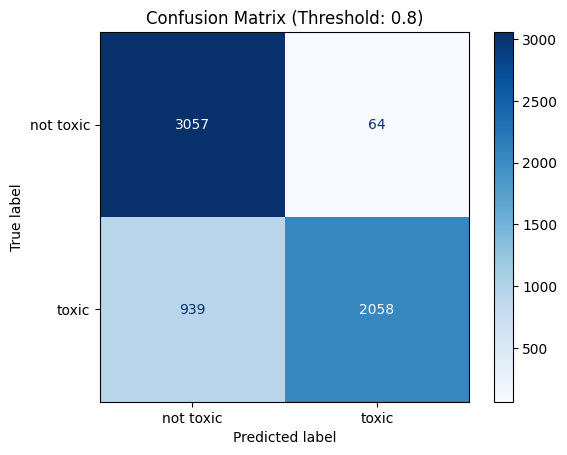

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_thresholds(y_true, y_probs, thresholds):
    """
    Evaluate and plot the confusion matrix for different thresholds.

    Args:
        y_true (list or np.array): True labels (0 or 1).
        y_probs (list or np.array): Predicted probabilities.
        thresholds (list): List of thresholds to evaluate.
    """
    for threshold in thresholds:
        # Convert probabilities to binary predictions
        y_pred = (y_probs >= threshold).astype(int)

        # Compute confusion matrix
        cfm4 = confusion_matrix(y_true, y_pred)

        # Print threshold and classification report
        print(f"\nThreshold: {threshold}")
        print(classification_report(y_true, y_pred, target_names=["not toxic", "toxic"]))

        # Display confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cfm4, display_labels=["not toxic", "toxic"])
        disp.plot(cmap='Blues')  # Optional: Use a color map
        plt.title(f"Confusion Matrix (Threshold: {threshold})")
        plt.show()

# Example predicted probabilities (replace with your model's predictions)
# Ensure `model.predict_proba` returns probabilities for the positive class
y_probs = model4.predict_proba(X_test)[:, 1]
thresholds = [0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Call the function
evaluate_thresholds(y_test, y_probs, thresholds)

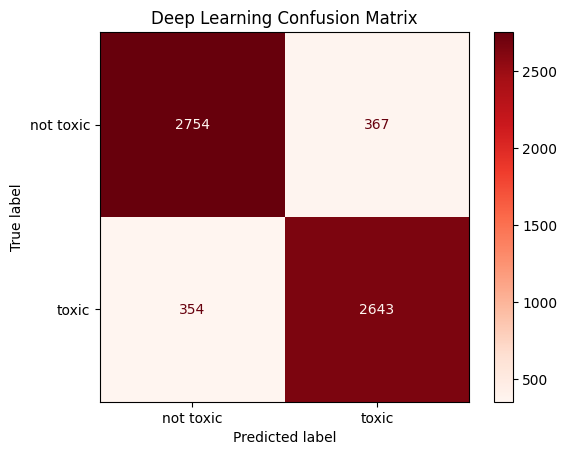

In [ ]:
dispdeep = ConfusionMatrixDisplay(confusion_matrix=cfmdeep, display_labels=["not toxic", "toxic"])
dispdeep.plot(cmap='Reds')  # Optional: Use a color map
plt.title("Deep Learning Confusion Matrix")
plt.show()